In [1]:
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid", color_codes=True)  # plotting style

In [2]:
from __future__ import annotations

from typing import List, Tuple

class Organism(object):
    """
    Params
    ----------
        'dims': hidden dimensions of model
        'output_fn': output activation function
        'mutation_lower': mutation rate lower bound
        'mutation_upper': mutation rate upper bound
    """
    def __init__(
        self,
        dims: List[int],
        output_fn="softmax",
        mutation_lower: float = 0.01,
        mutation_upper: float = 0.05
    ):
        self._init_nn(dims=dims, output_fn=output_fn)
        self.mutation_lower = mutation_lower
        self.mutation_upper = mutation_upper

    def _init_nn(self, dims: List[int], output_fn: str) -> None:
        """
        Initialize Neural Net
        """
        self.w, self.b = [], []  # weights, biases
        for shape in zip(dims[:-1], dims[1:]):
            std = np.sqrt(2 / sum(shape))
            self.w.append(np.random.normal(0, std, shape))
            self.b.append(np.random.normal(0, std, (1, shape[-1])))

        self.relu = lambda x: np.clip(x, 0, np.inf)
        if output_fn == "softmax":
            self.output_fn = lambda x : np.exp(x) / np.sum(np.exp(x), axis=1).reshape(-1, 1)
        elif output_fn == "linear":
            self.output_fn = lambda x: x

    def predict(self, X: np.ndarray) -> np.ndarray:
        assert X.ndim == 2, "Input must be 2D"
        for w, b in zip(self.w[:-1], self.b[:-1]):
            X = self.relu(np.matmul(X, w) + b)
        outputs = np.matmul(X, self.w[-1]) + self.b[-1]
        return self.output_fn(outputs)

    def mutate(self) -> None:
        noise = np.random.uniform(low=self.mutation_lower, high=self.mutation_upper)
        for idx in range(len(self.w)):
            self.w[idx] += np.random.normal(0, noise, self.w[idx].shape)
            self.b[idx] += np.random.normal(0, noise, self.b[idx].shape)

    def mate(self, other: Organism) -> Organism:
        for a, b in zip(self.w, other.w):
            assert a.shape == b.shape, "Weights of both parents must have same shape"

        child = deepcopy(self)
        for i in range(len(child.w)):
            mask = np.random.rand(1, child.w[i].shape[1]) < 0.5
            child.w[i] = mask * self.w[i] + ~mask * other.w[i]
            child.b[i] = mask * self.b[i] + ~mask * other.b[i]
        child.mutate()
        return child


class Environment(object):
    """
    Params
    ---------
        'gensis_fn': function that generates an organism
        'fitness_fn': negated loss function (we want to maximize)
        'population_size': size of each generation
        'sample_size': size of the samples ingested by organisms
        'holdout': number of organisms that are ensured survival
    """
    def __init__(
        self,
        gensis_fn: Callable,
        fitness_fn: Callable,
        population_size: int,
        sample_size: int,
        holdout='sqrt',
    ):
        self.population_size = population_size
        self.population = [gensis_fn() for _ in range(population_size)]
        self.fitness_fn = fitness_fn
        self.sample_size = sample_size
        if isinstance(holdout, int):
            self.holdout = holdout
        elif isinstance(holdout, float):
            assert 0. < holdout < 1
            self.holdout = max(1, int(holdout * population_size))
        elif holdout == "sqrt":
            self.holdout = max(1, int(np.sqrt(population_size)))
        self.generation = 0

    def generation_step(self, keep_best=True):
        rewards = []
        for p in self.population:
            sample_X, sample_y = self.generate_sample(sample_size=100)
            sample_yhat = p.predict(sample_X)
            rewards.append(self.fitness_fn(sample_y, sample_yhat))
        self.population = [self.population[x] for x in np.argsort(rewards)[::-1]]
        new_population = []
        for idx in range(self.population_size):
            parent_1_idx = idx % self.holdout
            parent_2_idx = min(self.population_size - 1, int(np.random.exponential(self.holdout)))
            offspring = self.population[parent_1_idx].mate(self.population[parent_2_idx])
            new_population.append(offspring)
        if keep_best:
            new_population[-1] = self.population[0] # Ensure best organism survives
        self.population = new_population

    def get_fittest(self) -> Tuple[Organism, float]:
        rewards = []
        for p in self.population:
            sample_X, sample_y = self.generate_sample(sample_size=self.sample_size)
            sample_yhat = p.predict(sample_X)
            rewards.append(self.fitness_fn(sample_y, sample_yhat))
        best_idx = np.argsort(rewards)[-1]
        return self.population[best_idx], rewards[best_idx]
    
    def step(self, n_generations: int, keep_best: bool = True) -> None:
        for _ in range(n_generations):
            self.generation_step(keep_best=keep_best)
            self.generation += 1
    
    def generate_sample(self, sample_size: int) -> Tuple[np.ndarray]:
        X = np.random.random((sample_size, 1))
        y = np.sin(2*np.pi*X)
        return X, y


env = Environment(
    gensis_fn=lambda: Organism([1, 32, 32, 1], output_fn="linear"),
    fitness_fn=lambda y, yhat: -np.mean((y - yhat)**2),  # negative MSE
    population_size=200,
    sample_size=128,
    holdout="sqrt",
)
env.step(500)


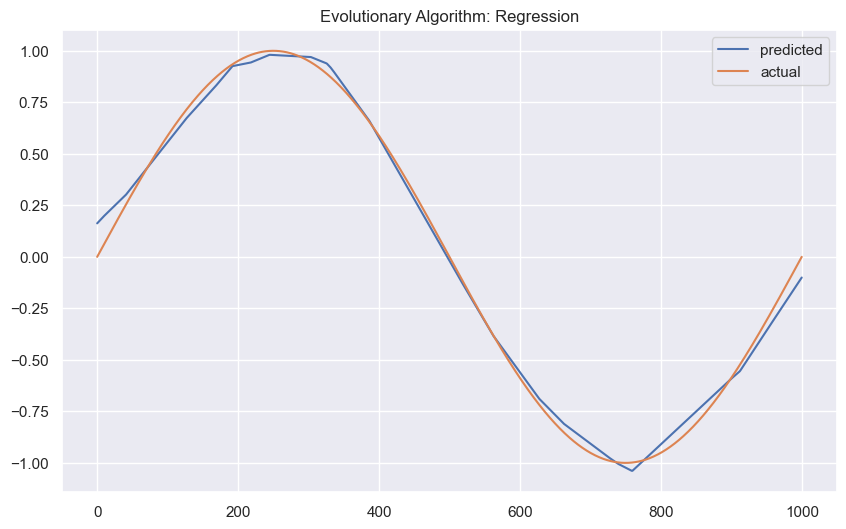

In [3]:
best_organism, best_score = env.get_fittest()
test_X = np.expand_dims(np.linspace(0., 1., 1000), 1)
yhat = best_organism.predict(test_X)

plt.figure(figsize=(10,6))
plt.plot(yhat, label="predicted")
plt.plot(np.sin(2*np.pi*test_X), label="actual")
plt.title("Evolutionary Algorithm: Regression")
plt.legend()
plt.show()


### MNIST Example

In [4]:
import pandas as pd
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784")
X, y = mnist.data, mnist.target

/Users/trevor/Projects/blog/neuroevolution/env/lib/python3.9/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [5]:
train_perc = 0.7
split_idx = int(len(X) * train_perc)

train_X, train_y = X[:split_idx].values, y[:split_idx].astype(int).values
test_X, test_y = X[split_idx:].values, y[split_idx:].astype(int).values

train_X = train_X / 255.
test_X = test_X / 255.

train_X.shape, train_y.shape

((49000, 784), (49000,))

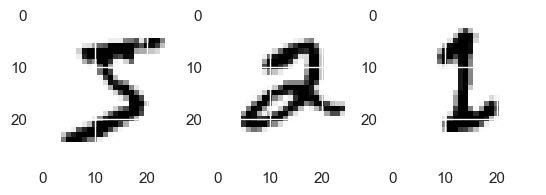

In [6]:
fix, axs = plt.subplots(1, 3)
axs[0].imshow((train_X[0].reshape(28,28)), cmap=plt.cm.gray_r, interpolation="nearest")
axs[1].imshow((train_X[5].reshape(28,28)), cmap=plt.cm.gray_r, interpolation="nearest")
axs[2].imshow((train_X[70].reshape(28,28)), cmap=plt.cm.gray_r, interpolation="nearest")

In [7]:
class MNISTEnvironment(Environment):
    def __init__(
        self,
        features: np.ndarray,
        targets: np.ndarray,
        gensis_fn: Callable,
        fitness_fn: Callable,
        population_size: int,
        sample_size: int,
        holdout='sqrt',
    ):
        super(MNISTEnvironment, self).__init__(
            gensis_fn=gensis_fn,
            fitness_fn=fitness_fn,
            population_size=population_size,
            sample_size=sample_size,
            holdout=holdout
        )
        self.features = features
        self.targets = targets

    def generate_sample(self, sample_size: int) -> Tuple[np.ndarray]:
        mask = np.random.choice(len(self.features), sample_size)
        X = self.features[mask]
        y = self.targets[mask]
        return X, y


def categorical_cross_entropy(y: np.ndarray, yhat: np.ndarray, sparse: bool = True):
    yhat = np.clip(yhat, 1e-7, 1.-1e-7)  # clip
    if sparse:  # categorical labels
        probabilities = yhat[range(len(yhat)), y]
    else:  # one hot encoded
        probabilities = np.sum(yhat*y, axis=1)
    # we traditionally use negative log likelihood in deep learning,
    # however we are trying to maximize our fitness, not minimize our loss.
    # so we exclude the negation.
    log_likelihood = np.log(probabilities)
    # we take mean log-likelihood over all samples
    return np.mean(log_likelihood)


env = MNISTEnvironment(
    features=train_X,
    targets=train_y,
    gensis_fn=lambda: Organism([784, 256, 10], output_fn="softmax"),
    fitness_fn=categorical_cross_entropy,
    population_size=256,
    sample_size=256,
    holdout="sqrt",
)

In [8]:
from sklearn.metrics import accuracy_score

def batch(obj, size: int = 1):
    l = len(obj)
    for idx in range(0, l, size):
        yield obj[idx: min(idx + size, l)]

def evaluate(
    env,
    test_data: Tuple[np.ndarray],
    batch_size: int
):
    best_organism, best_score = env.get_fittest()
    test_X, test_y = test_data
    test_yhat = []
    for batch_X in batch(test_X, size=batch_size):
        batch_yhat = best_organism.predict(batch_X)
        batch_yhat = np.argmax(batch_yhat, axis=1).squeeze()
        test_yhat = np.concatenate([test_yhat, batch_yhat])
    acc = accuracy_score(test_y, test_yhat)
    return acc

test_results = {} 

In [9]:
for idx in range(40):
    env.step(20)
    acc = evaluate(env, test_data=(test_X, test_y), batch_size=256)
    test_results.update({env.generation: acc})
    print(f"Generation {env.generation} Test Accuracy = {acc*100:.2f}%")

Generation 20 Test Accuracy = 40.79%
Generation 40 Test Accuracy = 51.71%
Generation 60 Test Accuracy = 55.43%
Generation 80 Test Accuracy = 57.30%
Generation 100 Test Accuracy = 55.43%
Generation 120 Test Accuracy = 63.23%
Generation 140 Test Accuracy = 64.51%
Generation 160 Test Accuracy = 64.91%
Generation 180 Test Accuracy = 64.86%
Generation 200 Test Accuracy = 63.07%
Generation 220 Test Accuracy = 68.52%
Generation 240 Test Accuracy = 69.56%
Generation 260 Test Accuracy = 69.25%
Generation 280 Test Accuracy = 71.42%
Generation 300 Test Accuracy = 69.51%
Generation 320 Test Accuracy = 71.72%
Generation 340 Test Accuracy = 69.53%
Generation 360 Test Accuracy = 73.18%
Generation 380 Test Accuracy = 71.83%
Generation 400 Test Accuracy = 74.47%
Generation 420 Test Accuracy = 73.19%
Generation 440 Test Accuracy = 71.90%
Generation 460 Test Accuracy = 73.64%
Generation 480 Test Accuracy = 73.01%
Generation 500 Test Accuracy = 73.51%
Generation 520 Test Accuracy = 73.75%
Generation 540 T

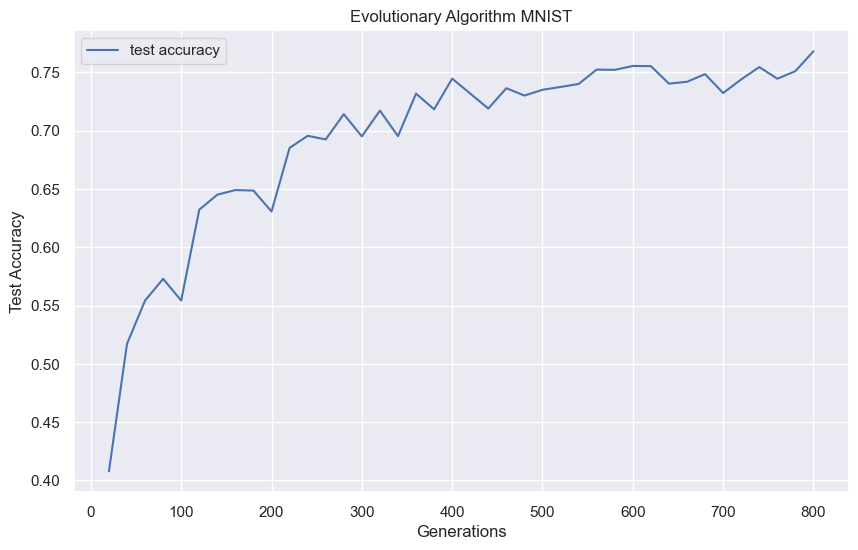

In [10]:
plt.figure(figsize=(10,6))
plt.plot(
    pd.Series(test_results), label="test accuracy"
)
plt.xlabel("Generations")
plt.ylabel("Test Accuracy")
plt.title("Evolutionary Algorithm MNIST")
plt.legend()
plt.show()

In [11]:
best_generation = max(test_results, key=lambda x: test_results[x])
best_acc = test_results[best_generation]
print("Best Generation:", best_generation)
print(f"Best Generation Test Accuracy: {best_acc*100:.2f}%")

Best Generation: 800
Best Generation Test Accuracy: 76.81%
